In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import find_peaks

Secluding 'X_train' according to 'target_train'

In [3]:
#Loading data
data = pd.read_csv('data.csv')
target_train = pd.read_csv('target_train.csv')

#Secluding
X_train = data[data['id'].isin(target_train['id'])]
X_train.to_csv('X_train.csv', index=False)

# Checking if ID's match
unames_X_train = X_train['id'].unique()
unames_target_train = target_train['id'].unique()
set(unames_X_train) == set(unames_target_train)

True

Visualize just to have a look

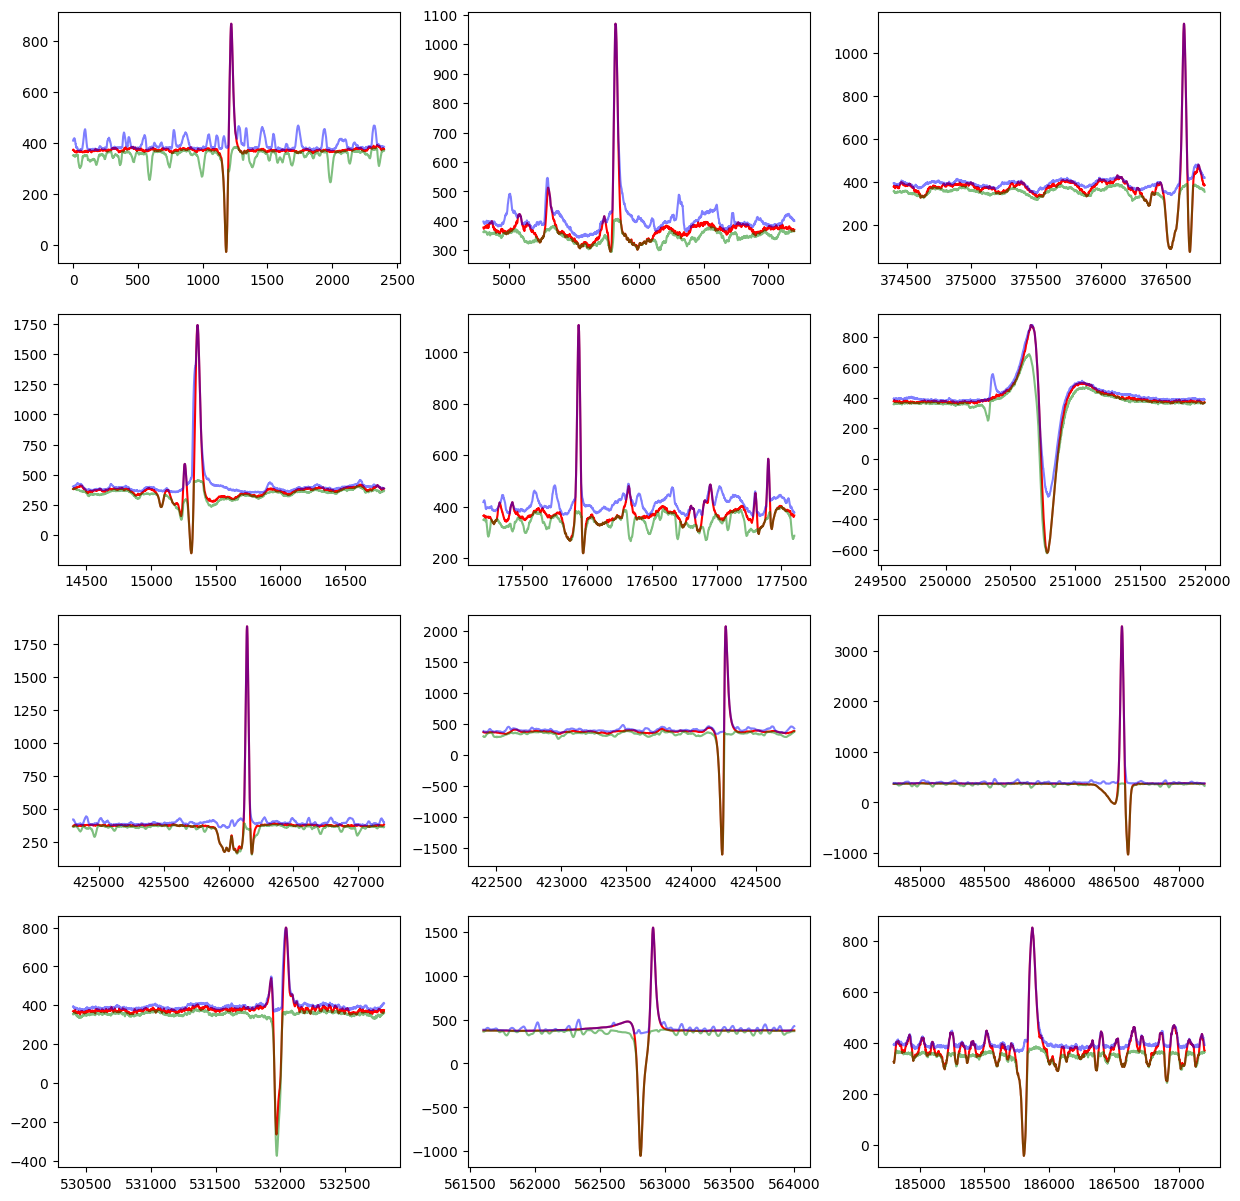

In [4]:
ID = ['1_1','4_1','6_2','8_1','105_1','160_1','41_2','37_2','80_2','111_2','144_2','109_1']
samples = [X_train[X_train['id']==pid] for pid in ID]

fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i, ax in enumerate( axs.flat):
    ax.plot(samples[i]['ch0'], c='r', alpha=1, label='ch0')
    ax.plot(samples[i]['ch1'], c='g', alpha=0.5, label='ch1')
    ax.plot(samples[i]['ch2'], c='b', alpha=0.5, label='ch2')

EDA + Feature engineering

In [136]:
def extract_statistical_features(channel):
    features = {}
    features['mean'] = np.mean(channel)
    features['std_dev'] = np.std(channel)
    features['min'] = np.min(channel)
    features['max'] = np.max(channel)
    features['range'] = features['max'] - features['min']
    features['skewness'] = pd.Series(channel).skew()
    features['kurtosis'] = pd.Series(channel).kurt()
    return features

def extract_frequency_features(channel):
    fft_values = fft(channel)
    fft_magnitude = np.abs(fft_values)  # Get magnitude
    features = {}
    features['fft_mean'] = np.mean(fft_magnitude)
    features['fft_std_dev'] = np.std(fft_magnitude)
    features['fft_max'] = np.max(fft_magnitude)
    features['fft_peak_freq'] = np.argmax(fft_magnitude)  # Frequency of the largest peak
    return features

def extract_peak_features(channel):
    peaks, _ = find_peaks(channel)
    valleys, _ = find_peaks(-channel)
    features = {}
    features['num_peaks'] = len(peaks)
    features['num_valleys'] = len(valleys)
    if len(peaks) > 0:
        features['max_peak_height'] = max(channel[peaks])
    else:
        features['max_peak_height'] = 0
    if len(valleys) > 0:
        features['min_valley_depth'] = min(channel[valleys])
    else:
        features['min_valley_depth'] = 0
    return features

def channel_new_features(channel):
    stat = extract_statistical_features(channel)
    freq = extract_frequency_features(channel)
    peak = extract_peak_features(channel)
    channel_new_features = list(stat.values()) + list(freq.values()) + list(peak.values())
    return channel_new_features

# 'OD'->0, 'ID'->1
def sample_new_features(sample_ID, target_train):
    sample = X_train[X_train['id']==sample_ID]
    ch0 = np.array(sample['ch0'])
    ch1 = np.array(sample['ch1'])
    ch2 = np.array(sample['ch2'])
    ch0_new_features = channel_new_features(ch0)
    ch1_new_features = channel_new_features(ch1)
    ch2_new_features = channel_new_features(ch2)
    if target_train[target_train['id']==sample_ID]['target'].values[0] == 'ID':
        label = [1]
    else: label = [0]
    sample_new_features = np.array(ch0_new_features + ch1_new_features + ch2_new_features + label)
    return sample_new_features

In [138]:
dataset_new = np.empty((0, 46))
target_train = pd.read_csv('target_train.csv')

for sample_ID in X_train['id'].unique():
    dataset_new = np.vstack([dataset_new, sample_new_features(sample_ID, target_train)])

dataset_new_pd = pd.DataFrame(dataset_new)
dataset_new_pd.columns = [  'ch0_mean', 'ch0_std_dev', 'ch0_min', 'ch0_max', 'ch0_range', 'ch0_skewness', 'ch0_kurtosis',\
                            'ch0_fft_mean', 'ch0_fft_std_dev', 'ch0_fft_max', 'ch0_fft_peak_freq',\
                            'ch0_num_peaks', 'ch0_num_valleys', 'ch0_max_peak_height', 'ch0_min_valley_depth',\
                            
                            'ch1_mean', 'ch1_std_dev', 'ch1_min', 'ch1_max', 'ch1_range', 'ch1_skewness', 'ch1_kurtosis',\
                            'ch1_fft_mean', 'ch1_fft_std_dev', 'ch1_fft_max', 'ch1_fft_peak_freq',\
                            'ch1_num_peaks', 'ch1_num_valleys', 'ch1_max_peak_height', 'ch1_min_valley_depth',\
                            
                            'ch2_mean', 'ch2_std_dev', 'ch2_min', 'ch2_max', 'ch2_range', 'ch2_skewness', 'ch2_kurtosis',\
                            'ch2_fft_mean', 'ch2_fft_std_dev', 'ch2_fft_max', 'ch2_fft_peak_freq',\
                            'ch2_num_peaks', 'ch2_num_valleys', 'ch2_max_peak_height', 'ch2_min_valley_depth', 'label',\
                            ]
dataset_new_pd.to_csv('dataset_new.csv', index=False)
dataset_new_pd

,ch0_mean,ch0_std_dev,ch0_min,ch0_max,ch0_range,ch0_skewness,ch0_kurtosis,ch0_fft_mean,ch0_fft_std_dev,ch0_fft_max,...,ch2_kurtosis,ch2_fft_mean,ch2_fft_std_dev,ch2_fft_max,ch2_fft_peak_freq,ch2_num_peaks,ch2_num_valleys,ch2_max_peak_height,ch2_min_valley_depth,label
0,372.823823,59.442505,-27.284988,866.018051,893.303039,2.156090,38.461237,1009.267683,18467.696487,894777.175667,...,46.918105,990.351975,19672.212492,9.577438e+05,0.0,314.0,313.0,866.018051,370.403059,0.0
1,375.149900,77.344105,295.275900,1069.721045,774.445145,6.277170,46.268748,1180.988287,18727.845716,900359.759009,...,41.300220,1207.711765,20419.434044,9.858436e+05,0.0,428.0,428.0,1069.721045,342.370537,0.0
2,374.982172,168.272847,-151.375620,1742.501576,1893.877196,5.247763,36.703664,1949.771564,20040.561444,899957.211991,...,35.619476,1959.493692,22168.786212,1.012324e+06,0.0,406.0,406.0,1742.501576,350.967177,0.0
3,373.964124,50.742319,26.163687,794.628561,768.464874,2.052328,38.710235,922.852840,18465.259816,897513.897362,...,48.430578,902.846493,19593.436209,9.557558e+05,0.0,322.0,322.0,794.628561,368.907991,0.0
4,373.030329,29.345717,141.283912,652.223348,510.939437,2.262554,51.486635,781.699750,18314.465874,895272.790659,...,26.080038,790.693192,19385.728995,9.479085e+05,0.0,347.0,348.0,652.223348,370.776826,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,372.790496,182.165909,-1152.697310,1640.089429,2792.786739,-1.944782,39.568364,2415.291921,20182.754467,894697.189537,...,74.211898,1895.696755,20677.316164,9.802625e+05,0.0,350.0,351.0,1640.089429,344.239372,0.0
96,373.316417,212.019916,-1053.275298,1547.395222,2600.670520,-1.733684,23.128417,2066.673508,20930.625439,895959.400567,...,50.024992,1647.783898,21223.747544,9.994409e+05,0.0,99.0,99.0,1547.395222,342.744304,0.0
97,374.059590,330.607786,-5815.440159,739.311050,6554.751210,-13.899094,215.603396,7014.233200,23429.330711,897743.016509,...,11.096189,972.108184,20334.474950,9.856900e+05,0.0,381.0,382.0,739.311050,366.291623,0.0
98,370.578730,52.999570,192.116218,483.280682,291.164463,-1.411352,2.449415,841.552759,18319.986549,889388.951145,...,0.382229,647.414837,20028.294193,9.801627e+05,0.0,444.0,445.0,483.280682,354.704847,1.0
